## Implementing softmax regression for the CIFAR-10 dataset
In this assignment, you will implement a multi-class logistic regression, or softmax regression classifier, and apply it to a version of the CIFAR-10 object recognition dataset. This process involves writing vectorized versions of the softmax loss and gradient functions, choosing learning rates and regularization parameters for the optimization algorithm, and visualizing the learned coefficients of the model.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

## Load the CIFAR-10 dataset
Open up a terminal window and navigate to the **datasets** folder inside the  **hw3** folder. Run the
**get\_datasets.sh**  script. On my Mac, I just type in **./get\_datasets.sh** at the shell prompt.
A new folder called **cifar\_10\_batches\_py** will be created and it will contain $50000$ labeled
images for training and $10000$ labeled images for testing. The function further partitions the $50000$ training 
images into a train set and a validation set for selection of hyperparameters. We have provided a function to
read this data in **utils.py**. Each image is a $32 \times 32$ array of RGB triples. It is preprocessed by
subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size
3072 (i.e., $32\times 32 \times 3$). Then a 1 is appended to the front of that vector to handle 
the intercept term.  So the training set is a numpy matrix of size $49000\times 3073$, 
the validation set is a matrix of size $1000\times 3073$ and the set-aside test set 
is of size $10000\times 3073$.

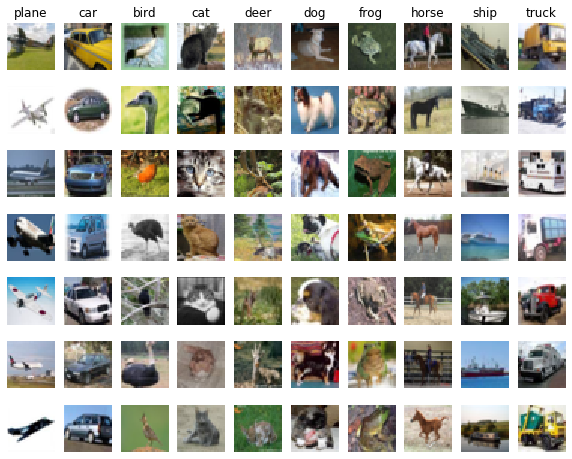

Training data shape: 49000,3072
Validation data shape: 1000,3072
Test data shape: 10000,3072
Training data shape with bias term: 49000,3073
Validation data shape with bias term: 1000,3073
Test data shape with bias term: 10000,3073


In [2]:
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

## Implementing the loss function for softmax regression (naive version) 
Softmax regression generalizes logistic regression to classification problems where the class label $y$ can take on more than two possible values. This is useful for such problems as music genre classification and object recognition, where the goal is to distinguish between more than two different music genres or more than two different object categories.  Softmax regression is a supervised learning algorithm, but we will later be using it in conjunction with deep learning and unsupervised feature learning methods.
Recall that we are  given a data set 
$${\cal D} = \{(x^{(i)},y^{(i)}) | 1 \leq i \leq m; x^{(i)} \in \Re^{d+1}; {x_0}^{(i)} = 1, y^{(i)} \in \{1,\ldots, K\}\}, K>2 $$
Our probabilistic model $h_\theta(x)$ is defined as
\begin{eqnarray*}
 h_\theta(x) & = & 
 \left [ \begin{array}{l}
 P(y = 1|x; \theta) \\
 P(y = 2| x; \theta) \\
 \ldots \\
 P(y=K|x;\theta)
 \end{array} \right ]
 \end{eqnarray*}
 where 
 $$ P(y=k|x; \theta) = \frac{exp({\theta^{(k)}}^T x)} {\sum_{j=1}^{K} exp({\theta^{(j)}}^T x)} $$

The parameter  $\theta$ is a $(d+1)\times K$ matrix, where each column represents the parameter vector for class $k = 1,\ldots,K$.
$$\theta = \left [ \begin{array}{llll}
| & | & \ldots & | \\
| & | & \ldots & | \\
\theta^{(1)} & \theta^{(2)} & \ldots & \theta^{(K)} \\
|&  | & \ldots & | \\
| & | & \ldots  &| \\
\end{array}
\right ] $$

Numerical stability issues can come up in the computation of $P(y=k|x;\theta)$. Consider K=3, and $\theta^T x = [123, 456, 789]$. To compute $P(y=k|x;\theta)$ from these scores, we need to calculate $exp(123)$, $exp(456)$ and $exp(789)$, and sum them. These are very large numbers. However, we can get the same probabilities by subtracting the maximum ($789$) from  every element in $\theta^Tx$. Then we have the vector
$[-666,-333,0]$, and we can calculate $exp(-666)$, $exp(-333)$ and $exp(0)$, sum them (call the sum $S$) and then calculate $exp(-666)/S$, $exp(-333/S)$ and $exp(0)/S$.
 
The cost function $J(\theta)$ for softmax regression is derived from the negative log likelihood of the data ${\cal D}$, assuming that  $P(y|x;\theta) = h_\theta(x)$ as defined above.

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} I\{y^{(i)} = k\} log \frac{exp({\theta^{(k)}}^T x^{(i)})}{\sum_{j=1}^{K} exp({\theta^{(j)}}^T x^{(i)})}  + \frac{\lambda}{2m} \sum_{j=0}^{d}\sum_{k=1}^{K} {{\theta_j}^{(k)}}^2 $$

where $I\{c\}$ is the indicator function which evaluates to 1 when $c$ is a true statement and to $0$ otherwise. The second term is a regularization term, where $\lambda$ is the regularization strength. While it is customary to exclude the bias term in L2 regularization, we include it here because it does not make a huge difference in the final result. You can check this for yourself on the CIFAR-10 dataset. You should implement this loss function using **for** loops for the summations in the function **softmax\_loss\_naive** in **softmax.py**. Once you have the loss function implemented, the cell below will run your loss function for a randomly initialized $\theta$ matrix with 49000 training images and labels with $\lambda$ set to 0. You should expect to see a value of about $-log_e(0.1)$ (Why?).

In [3]:
from softmax import softmax_loss_naive, softmax_loss_vectorized

# First implement the naive softmax loss function with nested loops.
# Open the file softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax theta matrix and use it to compute the loss.

theta = np.random.randn(3073,10) * 0.0001
loss, grad = softmax_loss_naive(theta, X_train, y_train, 0.0)

# Loss should be something close to 2.32

print ('loss: (should be close to 2.32): ', loss)

loss: (should be close to 2.32):  2.411238431935422


## Implementing the gradient of loss function for softmax regression (naive version) 
The derivative of the loss function $J(\theta)$ with respect to the $\theta^{(k)}$ is

$$ \nabla_{\theta^{(k)}} J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [x^{(i)} (1\{y^{(i)}=k\} - P(y^{(i)}=k|x^{(i)};\theta))] +\frac{\lambda}{m} \theta^{(k)}$$

Implement the analytical derivative computation in **softmax\_loss\_naive** in **softmax.py**.

We  check your implementation of the gradient using the method of finite differences. The functions in ** gradient\_check.py** compute the numerical gradient of a function $f$ as follows:
$$ \frac{\partial f(x)}{\partial x} = \frac{f(x+h)-f(x-h)}{2h} $$
for a very small $h$. The cell below will check your gradient against the numerically approximated gradient -- you should expect to see differences between the two gradients of the order of $10^{-7}$ or less. 


In [4]:
import time
# Open the file softmax.py and implement the gradient in the
# softmax_loss_naive function.

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient. (within 1e-7)

from gradient_check import grad_check_sparse
f = lambda th: softmax_loss_naive(th, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad, 10)

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(theta, X_train, y_train, 0.00001)
toc = time.time()
print('naive loss: %e computed in %f s' % (loss_naive, toc - tic))

numerical: 0.455303 analytic: 0.455303, relative error: 9.742372e-11
numerical: -1.546652 analytic: -1.546652, relative error: 2.677443e-09
numerical: -1.142398 analytic: -1.142398, relative error: 1.598334e-08
numerical: -0.486091 analytic: -0.486090, relative error: 3.197782e-08
numerical: 0.059100 analytic: 0.059099, relative error: 8.123522e-07
numerical: -0.125461 analytic: -0.125461, relative error: 1.445773e-08
numerical: -0.073671 analytic: -0.073671, relative error: 6.497026e-07
numerical: -0.101604 analytic: -0.101604, relative error: 9.778034e-08
numerical: -0.234706 analytic: -0.234706, relative error: 9.298394e-10
numerical: 0.671339 analytic: 0.671339, relative error: 8.761039e-09
naive loss: 2.411238e+00 computed in 8.708717 s


## Implementing the loss function and its gradient for softmax regression (vectorized version) 
Now complete the function **softmax\_loss\_vectorized** in **softmax.py** to implement the loss function $J(\theta)$ without using any **for** loops. Re-express the computation in terms of matrix operations on $X$, $y$ and $\theta$. 
Now vectorize the gradient computation in **softmax\_loss\_vectorized** in **softmax.py**. Once you complete this, the cell below will run and time your naive and vectorized implementations -- you should expect to see at least one order of magnitude difference in run time between the two implementations. 

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(theta, X_train, y_train, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %f s' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

vectorized loss: 2.411238e+00 computed in 0.530580 s
Loss difference: 0.000000
Gradient difference: 0.000000


## Implementing mini-batch gradient descent 
In large-scale applications, the training data can have millions of examples. Hence, it seems wasteful to compute the  loss function over the entire training set in order to perform only a single parameter update. A very common approach to addressing this challenge is to compute the gradient over batches of the training data. For example, a typical batch contains 256 examples from a training set of over 1.2 million. This batch is then used to perform a parameter update:
$$ \theta^{(k)} \to \theta^{(k)} - \alpha \nabla_{\theta^{(k)}} J(\theta) $$
where $\alpha$ is the step size or learning rate for gradient descent.

Implement mini-batch gradient descent in the method **train** in **linear_classifier.py** using the description provided in the documentation of the method. You can set the **verbose** argument of **train** to be **True** and observe how the loss function varies with iteration number.

You will test your implementation of mini-batch gradient descent in the search for hyperparameters below.

## Using a validation set to select regularization lambda and learning rate for   gradient descent
There are many hyper parameters to be selected for mini batch gradient descent -- the batch size, the number of iterations, and the learning rate. For the loss function, we also need to select $\lambda$, the regularization strength. In this exercise, we have pre-selected a batch size of 400 and an iteration count of 4000. Now, use the validation set provided to sweep the learning rate and the $\lambda$ parameter space, using the suggested values in the cell below to find the best combination of these two hyper parameters. Fill in the code to do this in the section marked **TODO** below.

Once you find the best values of $\lambda$ and learning rate, insert code in the cell below to train a softmax classifier on the training data with the best hyper parameters and save this classifier in the variable  **best\_softmax**.  

In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################
model = linear_classifier.Softmax()
for l in learning_rates:
    for reg in regularization_strengths:
        model.train(X_train, y_train, learning_rate=l, reg=reg, num_iters=600, batch_size=400, verbose=True)
        train_accuracy = np.mean(model.predict(X_train) == y_train)
        val_accuracy = np.mean(model.predict(X_val) == y_val)
        results[l, reg] = {train_accuracy, val_accuracy}
# model.train(X_train, y_train, learning_rate=5e-6, reg=1e8, num_iters=4000, batch_size=400, verbose=True)
# train_accuracy = np.mean(model.predict(X_train) == y_train)
# val_accuracy = np.mean(model.predict(X_val) == y_val)
# results[l, reg] = {train_accuracy, val_accuracy}
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    best_val = max(best_val, val_accuracy)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 600: loss 7.609410
iteration 100 / 600: loss 5.754690
iteration 200 / 600: loss 5.278165
iteration 300 / 600: loss 5.250618
iteration 400 / 600: loss 4.938255
iteration 500 / 600: loss 5.033158
iteration 0 / 600: loss 6.924384
iteration 100 / 600: loss 6.432185
iteration 200 / 600: loss 6.497747
iteration 300 / 600: loss 6.469132
iteration 400 / 600: loss 6.070638
iteration 500 / 600: loss 6.181047
iteration 0 / 600: loss 20.366002
iteration 100 / 600: loss 19.834281
iteration 200 / 600: loss 19.438630
iteration 300 / 600: loss 18.818724
iteration 400 / 600: loss 18.486585
iteration 500 / 600: loss 18.106170
iteration 0 / 600: loss 3041.753260
iteration 100 / 600: loss 21.380676
iteration 200 / 600: loss 2.332027
iteration 300 / 600: loss 2.198115
iteration 400 / 600: loss 2.195124
iteration 500 / 600: loss 2.191864
iteration 0 / 600: loss 2.115289
iteration 100 / 600: loss 1.832748
iteration 200 / 600: loss 1.789700
iteration 300 / 600: loss 1.734244
iteration 400 / 600:

In [14]:
# lr 5.000000e-07 reg 5.000000e+05 train accuracy: 0.413449 val accuracy: 0.415000
# best validation accuracy achieved during cross-validation: 0.415000

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################
model.train(X_train, y_train, learning_rate=5e-7, reg=5e5, num_iters=4000, batch_size=400, verbose=True)
train_accuracy = np.mean(model.predict(X_train) == y_train)
val_accuracy = np.mean(model.predict(X_val) == y_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    best_val = max(best_val, val_accuracy)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 4000: loss 6.913585
iteration 100 / 4000: loss 1.897035
iteration 200 / 4000: loss 1.795145
iteration 300 / 4000: loss 1.772758
iteration 400 / 4000: loss 1.809457
iteration 500 / 4000: loss 1.774737
iteration 600 / 4000: loss 1.805202
iteration 700 / 4000: loss 1.780291
iteration 800 / 4000: loss 1.861440
iteration 900 / 4000: loss 1.758744
iteration 1000 / 4000: loss 1.788739
iteration 1100 / 4000: loss 1.853122
iteration 1200 / 4000: loss 1.855016
iteration 1300 / 4000: loss 1.836237
iteration 1400 / 4000: loss 1.799940
iteration 1500 / 4000: loss 1.835617
iteration 1600 / 4000: loss 1.806930
iteration 1700 / 4000: loss 1.777173
iteration 1800 / 4000: loss 1.867786
iteration 1900 / 4000: loss 1.852484
iteration 2000 / 4000: loss 1.834866
iteration 2100 / 4000: loss 1.828851
iteration 2200 / 4000: loss 1.746752
iteration 2300 / 4000: loss 1.853141
iteration 2400 / 4000: loss 1.691458
iteration 2500 / 4000: loss 1.763902
iteration 2600 / 4000: loss 1.836800
iteration 270

## Evaluating the best softmax classifier on the test set and visualizing the coefficients
The best\_softmax classifier will be  evaluated on the set aside test set and you should expect to see an overall accuracy of over 35%. 

Compute the confusion matrix (you can use the confusion\_matrix function in **sklearn.metrics** on the test set for your predictor and interpret the visualized coefficients in the light of the errors made by the classifier.

We can remove the bias term from the $\theta$ matrix and reshape each column of the matrix which is a parameter vector of size $3072$ back into an array of size $32\times 32 \times 3$ and visualize the results as an image. The cell below  constructs such a plot, similar to the one in Figure 2 in hw3.pdf. 

In [16]:
best_softmax = linear_classifier.Softmax()
best_softmax.train(X_train, y_train, learning_rate= 5e-7, reg= 5e5, num_iters=4000, batch_size=400, verbose=False)

[24.516453497408783,
 24.532261315396887,
 24.60685948936235,
 24.14480174261664,
 24.04287930427979,
 24.0826481512874,
 23.559239387144757,
 23.732878661269712,
 23.792273960725595,
 23.636531292916565,
 23.210117571292045,
 23.60292746886074,
 23.368688497835343,
 23.310271513779348,
 23.177486646990562,
 23.19936152630063,
 22.77050418502261,
 22.831105657367655,
 22.815034111520582,
 22.51231846342623,
 22.795330841399764,
 22.80441818185658,
 22.723203906151575,
 22.48467464634026,
 22.32761881576071,
 22.441084197891396,
 22.50519604100687,
 22.434877152298178,
 22.311257088548334,
 22.15192153130589,
 22.19679434252299,
 22.122513817240836,
 22.143045235973798,
 22.06040206932821,
 22.099241854046944,
 22.01124005489514,
 21.82500409874309,
 22.035524094814388,
 21.69432179404405,
 21.79666968242642,
 21.589359705143806,
 21.663534248280467,
 21.64162344240828,
 21.861940646744294,
 21.599406488114088,
 21.378126538073293,
 21.629322315720746,
 21.4282678755931,
 21.33159065148

softmax on raw pixels final test set accuracy: 0.402500
[[503  52  38  23  13  25  26  38 203  79]
 [ 64 484  16  26  26  44  41  39  92 168]
 [114  59 230  70 121  88 171  60  56  31]
 [ 52  84  77 195  65 219 127  52  56  73]
 [ 61  33 117  43 316  88 185  87  36  34]
 [ 49  46  84 111  66 367 109  65  69  34]
 [ 19  55  55  81 100  88 506  28  25  43]
 [ 54  55  55  40 117  82  60 391  48  98]
 [159  72   5  10   9  63  11  12 542 117]
 [ 74 174  10  25  17  19  45  40 105 491]]


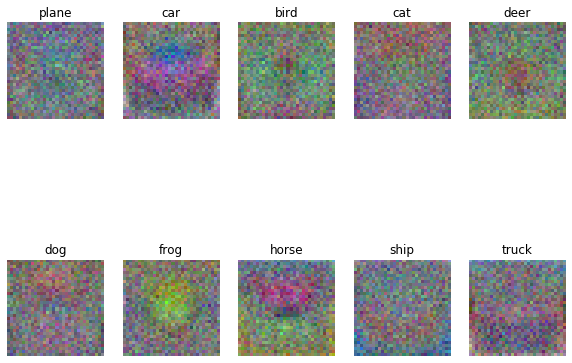

In [17]:
# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

# compute confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_test_pred))

# Visualize the learned weights for each class`

theta = best_softmax.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

plt.show()

## Extra credit:  Experimenting with other hyper parameters and optimization method
We chose a batch size of 400 and 4000 iterations for our previous experiments. Explore larger and smaller batch sizes, choosing an appropriate number of iterations (by specifying a tolerance on differences in values of the loss function or its gradient in successive iterations) with the validation set. Produce plots that show the variation of test set accuracy as a function of batch size/number of iterations. You will have to determine the right settings for regularization strength $\lambda$ and learning rate for each batch size/number of iterations combination. What is the best batch size/number of iterations/learning rate/regularization strength combination for this problem? What is the best test set accuracy that can be achieved by this combination? 

In [46]:
import linear_classifier
import pandas as pd

df_batch = pd.DataFrame()
df_iter = pd.DataFrame()
model = linear_classifier.Softmax()
results = {}
best_val = -1
best_softmax = None
batch_sizes = [i for i in range(200, 2000, 300)]
iter_numbers = [i for i in range(1000, 5000, 1000)]
for it in iter_numbers:
    df_iter[f'{it}'] = pd.Series(0)
for batch in batch_sizes:
    df_batch[f'{batch}'] = pd.Series(0)

for batch in batch_sizes:
    best = 0
    for it in iter_numbers:
        model.train(X_train, y_train, learning_rate=5e-7, reg=5e5, num_iters=it, batch_size=batch, verbose=True)
        train_accuracy = np.mean(model.predict(X_train) == y_train)
        val_accuracy = np.mean(model.predict(X_val) == y_val)
        test_accuracy = np.mean(model.predict(X_test) == y_test)
        df_iter[f'{it}'] = pd.Series(max(df_iter[f'{it}'].item(), test_accuracy))
        results[batch, it] = {train_accuracy, val_accuracy}
        best = max(test_accuracy, best)
    df_batch[f'{batch}'] = pd.Series(max(df_batch[f'{batch}'].item(), best))
for batch, it in sorted(results):
    train_accuracy, val_accuracy = results[(batch, it)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                batch, it, train_accuracy, val_accuracy))
    best_val = max(best_val, val_accuracy)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 43.618936
iteration 100 / 1000: loss 32.391893
iteration 200 / 1000: loss 25.337548
iteration 300 / 1000: loss 19.917321
iteration 400 / 1000: loss 15.782154
iteration 500 / 1000: loss 12.762075
iteration 600 / 1000: loss 10.361833
iteration 700 / 1000: loss 8.392718
iteration 800 / 1000: loss 6.962370
iteration 900 / 1000: loss 5.702824
iteration 0 / 2000: loss 4.845952
iteration 100 / 2000: loss 4.190739
iteration 200 / 2000: loss 3.722361
iteration 300 / 2000: loss 3.105025
iteration 400 / 2000: loss 2.985256
iteration 500 / 2000: loss 2.753746
iteration 600 / 2000: loss 2.468604
iteration 700 / 2000: loss 2.376435
iteration 800 / 2000: loss 2.275023
iteration 900 / 2000: loss 2.161732
iteration 1000 / 2000: loss 1.970782
iteration 1100 / 2000: loss 1.957933
iteration 1200 / 2000: loss 1.910753
iteration 1300 / 2000: loss 2.025962
iteration 1400 / 2000: loss 1.974072
iteration 1500 / 2000: loss 1.852004
iteration 1600 / 2000: loss 1.773779
iteration 1700 / 2

iteration 1500 / 2000: loss 1.769061
iteration 1600 / 2000: loss 1.711342
iteration 1700 / 2000: loss 1.776607
iteration 1800 / 2000: loss 1.763498
iteration 1900 / 2000: loss 1.750862
iteration 0 / 3000: loss 1.705705
iteration 100 / 3000: loss 1.726042
iteration 200 / 3000: loss 1.716517
iteration 300 / 3000: loss 1.743578
iteration 400 / 3000: loss 1.815781
iteration 500 / 3000: loss 1.776087
iteration 600 / 3000: loss 1.780616
iteration 700 / 3000: loss 1.722092
iteration 800 / 3000: loss 1.795057
iteration 900 / 3000: loss 1.747325
iteration 1000 / 3000: loss 1.726793
iteration 1100 / 3000: loss 1.740497
iteration 1200 / 3000: loss 1.745426
iteration 1300 / 3000: loss 1.774231
iteration 1400 / 3000: loss 1.767172
iteration 1500 / 3000: loss 1.710973
iteration 1600 / 3000: loss 1.776708
iteration 1700 / 3000: loss 1.722576
iteration 1800 / 3000: loss 1.773495
iteration 1900 / 3000: loss 1.743184
iteration 2000 / 3000: loss 1.797357
iteration 2100 / 3000: loss 1.725922
iteration 220

iteration 2000 / 3000: loss 1.688851
iteration 2100 / 3000: loss 1.706177
iteration 2200 / 3000: loss 1.716442
iteration 2300 / 3000: loss 1.702673
iteration 2400 / 3000: loss 1.724992
iteration 2500 / 3000: loss 1.738924
iteration 2600 / 3000: loss 1.717411
iteration 2700 / 3000: loss 1.755031
iteration 2800 / 3000: loss 1.732466
iteration 2900 / 3000: loss 1.724686
iteration 0 / 4000: loss 1.711030
iteration 100 / 4000: loss 1.693900
iteration 200 / 4000: loss 1.752120
iteration 300 / 4000: loss 1.731655
iteration 400 / 4000: loss 1.715396
iteration 500 / 4000: loss 1.702518
iteration 600 / 4000: loss 1.742584
iteration 700 / 4000: loss 1.747571
iteration 800 / 4000: loss 1.771760
iteration 900 / 4000: loss 1.696851
iteration 1000 / 4000: loss 1.734378
iteration 1100 / 4000: loss 1.712204
iteration 1200 / 4000: loss 1.725687
iteration 1300 / 4000: loss 1.718260
iteration 1400 / 4000: loss 1.733562
iteration 1500 / 4000: loss 1.696883
iteration 1600 / 4000: loss 1.728344
iteration 170

In [49]:
# lr 2.000000e+02 reg 1.000000e+03 train accuracy: 0.366184 val accuracy: 0.364000
# lr 2.000000e+02 reg 2.000000e+03 train accuracy: 0.403837 val accuracy: 0.408000
# lr 2.000000e+02 reg 3.000000e+03 train accuracy: 0.403224 val accuracy: 0.410000
# lr 2.000000e+02 reg 4.000000e+03 train accuracy: 0.403531 val accuracy: 0.405000
# lr 5.000000e+02 reg 1.000000e+03 train accuracy: 0.410714 val accuracy: 0.409000
# lr 5.000000e+02 reg 2.000000e+03 train accuracy: 0.416122 val accuracy: 0.417000
# lr 5.000000e+02 reg 3.000000e+03 train accuracy: 0.417510 val accuracy: 0.420000
# lr 5.000000e+02 reg 4.000000e+03 train accuracy: 0.418265 val accuracy: 0.410000
# lr 8.000000e+02 reg 1.000000e+03 train accuracy: 0.421347 val accuracy: 0.417000
# lr 8.000000e+02 reg 2.000000e+03 train accuracy: 0.424429 val accuracy: 0.417000
# lr 8.000000e+02 reg 3.000000e+03 train accuracy: 0.423429 val accuracy: 0.407000
# lr 8.000000e+02 reg 4.000000e+03 train accuracy: 0.426265 val accuracy: 0.412000
# lr 1.100000e+03 reg 1.000000e+03 train accuracy: 0.426796 val accuracy: 0.416000
# lr 1.100000e+03 reg 2.000000e+03 train accuracy: 0.428408 val accuracy: 0.422000
# lr 1.100000e+03 reg 3.000000e+03 train accuracy: 0.429082 val accuracy: 0.417000
# lr 1.100000e+03 reg 4.000000e+03 train accuracy: 0.430020 val accuracy: 0.408000
# lr 1.400000e+03 reg 1.000000e+03 train accuracy: 0.431163 val accuracy: 0.418000
# lr 1.400000e+03 reg 2.000000e+03 train accuracy: 0.433020 val accuracy: 0.419000
# lr 1.400000e+03 reg 3.000000e+03 train accuracy: 0.432551 val accuracy: 0.417000
# lr 1.400000e+03 reg 4.000000e+03 train accuracy: 0.434000 val accuracy: 0.411000
# lr 1.700000e+03 reg 1.000000e+03 train accuracy: 0.434714 val accuracy: 0.418000
# lr 1.700000e+03 reg 2.000000e+03 train accuracy: 0.436816 val accuracy: 0.414000
# lr 1.700000e+03 reg 3.000000e+03 train accuracy: 0.436429 val accuracy: 0.424000
# lr 1.700000e+03 reg 4.000000e+03 train accuracy: 0.436837 val accuracy: 0.414000
# best validation accuracy achieved during cross-validation: 0.424000
df_batch.to_csv('batch.csv')
df_iter.to_csv('iter.csv')

In [50]:
df_batch = pd.read_csv('batch.csv')
df_iter = pd.read_csv('iter.csv')

In [53]:
df_batch.loc[0]

Unnamed: 0    0.0000
200           0.3965
500           0.4060
800           0.4091
1100          0.4115
1400          0.4117
1700          0.4129
Name: 0, dtype: float64

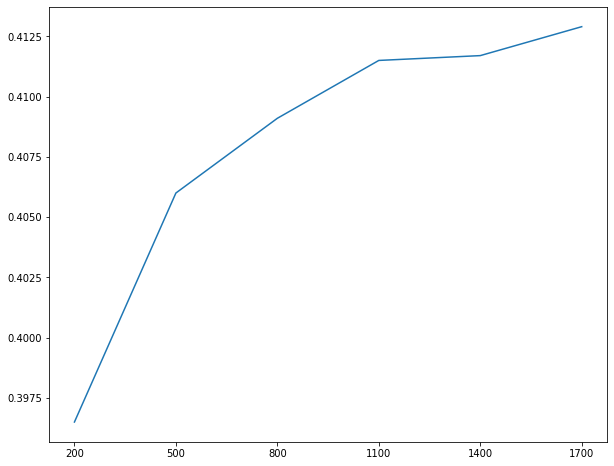

In [61]:
df_batch.loc[0][1:].plot()

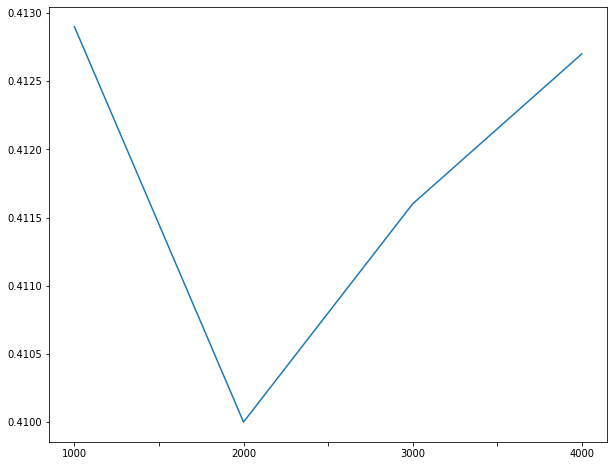

In [62]:
df_iter.loc[0][1:].plot()